# NLP and Neural Networks

In this exercise, we'll apply our knowledge of neural networks to process natural language. As we did in the bigram exercise, the goal of this lab is to predict the next word, given the previous one.

### Data set

Load the text from "One Hundred Years of Solitude" that we used in our bigrams exercise. It's located in the data folder.

### Important note:

Start with a smaller part of the text. Maybe the first 10 parragraphs, as the number of tokens rapidly increases as we add more text.

Later you can use a bigger corpus.

In [1]:
import torch
import matplotlib.pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Don't forget to prepare the data by generating the corresponding tokens.

In [2]:
text = open('/content/cap1.txt', 'r').read().lower()

In [3]:
tokens = tokenizer.tokenize(text)
print('# tokens:', len(tokens))
print('min len', min(len(x) for x in tokens))
print('max len', max(len(x) for x in tokens))
print(tokens[:10])

# tokens: 6293
min len 1
max len 16
['muchos', 'años', 'después', ',', 'frente', 'al', 'pelotón', 'de', 'fusilamiento', ',']


### Let's prepare the data set.

Our neural network needs to have an input X and an output y. Remember that these sets are numerical, so you'd need something to map the tokens into numbers, and viceversa.

In [4]:
# in this case, let's consider a bigram (w1, w2)
# assign the w1 to the X vector, and w2 to the y vector, why do we do this?

In [5]:
bigrams = {}

for (w1, w2) in zip(tokens, tokens[1:]):
  bigram = (w1, w2)
  bigrams[bigram] = bigrams.get(bigram, 0) + 1

uniq_tokens = sorted(list(set(tokens)))

token_to_idx = {ch: i for i, ch in enumerate(uniq_tokens)}
idx_to_token = {i: ch for i, ch in enumerate(uniq_tokens)}

print('len bigrams:', len(bigrams))
print('len uniq_tokens:', len(uniq_tokens))

print('bigrams:', bigrams)
print('uniq_tokens:', uniq_tokens)
print('token_to_idx:', token_to_idx)
print('idx_to_token:', idx_to_token)


len bigrams: 4914
len uniq_tokens: 2127
bigrams: {('muchos', 'años'): 3, ('años', 'después'): 2, ('después', ','): 2, (',', 'frente'): 1, ('frente', 'al'): 1, ('al', 'pelotón'): 2, ('pelotón', 'de'): 2, ('de', 'fusilamiento'): 2, ('fusilamiento', ','): 2, (',', 'el'): 10, ('el', 'coronel'): 3, ('coronel', 'aureliano'): 3, ('aureliano', 'buendía'): 4, ('buendía', 'había'): 2, ('había', 'de'): 4, ('de', 'recordar'): 2, ('recordar', 'aquella'): 1, ('aquella', 'tarde'): 2, ('tarde', 'remota'): 1, ('remota', 'en'): 1, ('en', 'que'): 12, ('que', 'su'): 7, ('su', 'padre'): 7, ('padre', 'lo'): 1, ('lo', 'llevó'): 3, ('llevó', 'a'): 3, ('a', 'conocer'): 3, ('conocer', 'el'): 2, ('el', 'hielo.'): 1, ('hielo.', 'macondo'): 1, ('macondo', 'era'): 1, ('era', 'entonces'): 1, ('entonces', 'una'): 2, ('una', 'aldea'): 3, ('aldea', 'de'): 1, ('de', 'veinte'): 1, ('veinte', 'casas'): 1, ('casas', 'de'): 1, ('de', 'barro'): 2, ('barro', 'y'): 1, ('y', 'cañabrava'): 1, ('cañabrava', 'construidas'): 1, ('c

In [6]:
# Don't forget that since we are using torch, our training set vectors should be tensors

In [7]:
# Note that our vectors are integers, which can be thought as a categorical variables.
# torch provides the one_hot method, that would generate tensors suitable for our nn
# make sure that the dtype of your tensor is float.

In [8]:
class BigramDataset(torch.utils.data.Dataset):
  def __init__(self, bigrams, uniq_tokens, token_to_idx, idx_to_token):
    super(BigramDataset, self).__init__()
    self.bigrams = bigrams
    self.uniq_tokens = uniq_tokens
    self.token_to_idx = token_to_idx
    self.idx_to_token = idx_to_token

  def __len__(self):
    return len(self.bigrams)

  def __getitem__(self, idx):
    bigram = list(self.bigrams.keys())[idx]
    x = torch.tensor(self.token_to_idx[bigram[0]])
    y = torch.tensor(self.token_to_idx[bigram[1]])
    x_one_hot = torch.nn.functional.one_hot(x, num_classes=len(self.uniq_tokens)).float()
    # y_one_hot = torch.nn.functional.one_hot(y, num_classes=len(self.uniq_tokens)).float()

    return x_one_hot, y

### Network design
To start, we are going to have a very simple network. Define a single layer network

In [9]:
# How many neurons should our input layer have?
# Use as many neurons as the total number of categories (from your one-hot encoded tensors)
# Use the softmax as your activation layer

In [10]:
class BasicNet(torch.nn.Module):
  def __init__(self):
    super(BasicNet, self).__init__()

    self.fc = torch.nn.Linear(
      in_features=len(uniq_tokens),
      out_features=len(uniq_tokens)
    )

    self.softmax = torch.nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc(x)
    x = self.softmax(x)

    return x

### Train your network

In [12]:
EPOCHS = 15
BATCH_SIZE = 512
LEARNING_RATE = 1.5e-1

dataset = BigramDataset(bigrams, uniq_tokens, token_to_idx, idx_to_token)
dataloader = torch.utils.data.DataLoader(dataset=dataset,
batch_size=BATCH_SIZE, shuffle=True)

basic_net = BasicNet()
# basic_net = basic_net.to(device)
basic_net.to('cpu')

def train_net(net, dataloader, epochs, lr):
  net.train()
  criterion = torch.nn.NLLLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  losses = []

  for epoch in range(EPOCHS):
      running_loss = 0.0

      for i, data in enumerate(dataloader):
        inputs, labels = data
        # inputs = inputs.to(device)
        # labels = labels.to(device)
        inputs = inputs.to('cpu')
        labels = labels.to('cpu')

        optimizer.zero_grad()

        outputs = net(inputs)
        log_outputs = torch.log(outputs)
        loss = criterion(log_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

      losses.append(running_loss)
      print(f'[Epoch {epoch + 1}/{EPOCHS}] loss: {running_loss / len(dataloader)}')

  print('Finished Training')

  return losses, net

losses, basic_net = train_net(basic_net, dataloader, EPOCHS, LEARNING_RATE)

[Epoch 1/15] loss: 7.394277954101563
[Epoch 2/15] loss: 5.440451145172119
[Epoch 3/15] loss: 4.269494485855103
[Epoch 4/15] loss: 3.5923721551895142
[Epoch 5/15] loss: 3.149581241607666
[Epoch 6/15] loss: 2.8300212144851686
[Epoch 7/15] loss: 2.611131477355957
[Epoch 8/15] loss: 2.456111216545105
[Epoch 9/15] loss: 2.3463052988052366
[Epoch 10/15] loss: 2.281835842132568
[Epoch 11/15] loss: 2.232245922088623
[Epoch 12/15] loss: 2.214211416244507
[Epoch 13/15] loss: 2.212009382247925
[Epoch 14/15] loss: 2.2035616397857667
[Epoch 15/15] loss: 2.1922564029693605
Finished Training


In [13]:
torch.save(basic_net, 'basic-model.pth')

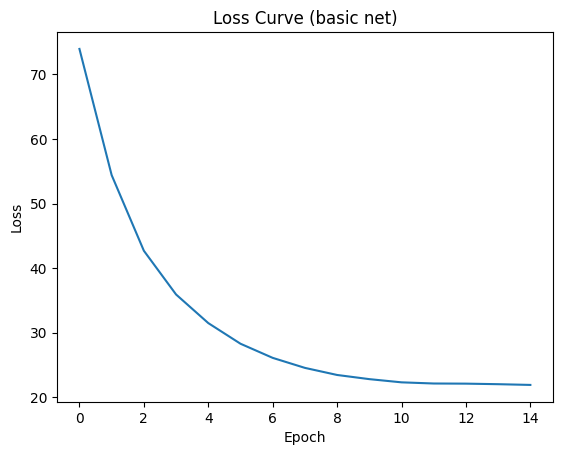

In [14]:
def plot_loss_curve(losses, title_suffix):
  plt.plot(losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Loss Curve ({title_suffix})')
  plt.show()

plot_loss_curve(losses, 'basic net')

### Analysis

1. Test your network with a few words

In [16]:
# Get an output tensor for each of your tests
def get_preds(net, inputs):
  net.eval()
  with torch.no_grad():
    # inputs = inputs.to(device)
    inputs = inputs.to('cpu')
    preds = net(inputs)
    return preds

def pretty_print_preds(inputs, preds, n_items, nll_pred):
  w1_index = torch.argmax(inputs, dim=1)
  w2_index = torch.argmax(preds, dim=1)

  for i in range(n_items):
    w1 = idx_to_token[w1_index[i].item()]
    w2 = idx_to_token[w2_index[i].item()]
    print(w1, w2, f'(nll={nll_preds[i].item()})')

x_test, y_test = next(iter(dataloader))
# x_test = x_test.to(device)
# y_test = y_test.to(device)
x_test = x_test.to('cpu')
y_test = y_test.to('cpu')
preds = get_preds(basic_net, x_test)
log_preds = torch.log(preds)
nll_preds = torch.nn.functional.nll_loss(log_preds, y_test, reduction='none')

n_items_to_print = 10
pretty_print_preds(x_test, preds, n_items_to_print, nll_preds)

enteras en (nll=0.03521320968866348)
niño , (nll=1.1348090171813965)
influencia terminante (nll=0.9562251567840576)
niños a (nll=2.4942822456359863)
mental , (nll=0.03733310475945473)
al cielo (nll=3.8046603202819824)
al cielo (nll=3.5542795658111572)
febriles. en (nll=0.041023265570402145)
llevó a (nll=0.7042129635810852)
no sólo (nll=3.517477035522461)


2. What does each value in the tensor represents?

The likelihood that the word corresponding to each index is a good fit to follow the input word.
3. Why does it make sense to choose that number of neurons in our layer?

Because it's a one-layer net and that layer acts as an implicit input and output layer (even though it's followed by a softmax) and the input should reflect the one-hot encoded vocabulary shape and the output should reflect the same shape, but with probabily values.
4. What's the negative likelihood for each example?

It can be seen in the output above (in parentheses.)
5. Try generating a few sentences?



In [36]:
def check_terminal_token(token):
  is_end_token = token == '.' or token == '!' or token == '?' or '.' in token
  return is_end_token

def generate_sentence(net, initial_word, token_to_idx, idx_to_token):
  sentence = [initial_word]
  net.eval()
  word = initial_word
  max_len = 20

  sentente_nll = 0

  while True:
    input_tensor = torch.nn.functional.one_hot(torch.tensor(token_to_idx[word]), num_classes=len(uniq_tokens)).float().unsqueeze(0)
    # input_tensor = input_tensor.to(device)
    input_tensor = input_tensor.to('cpu')
    next_word = net(input_tensor)
    sentente_nll += torch.nn.functional.nll_loss(torch.log(next_word), torch.tensor([token_to_idx[word]]), reduction='sum')
    next_word = torch.argmax(next_word, dim=1)
    sentence.append(idx_to_token[next_word.squeeze(0).item()])
    word = idx_to_token[next_word.squeeze(0).item()]

    max_len_reached = len(sentence) >= max_len
    if check_terminal_token(word) or max_len_reached:
      break

  return ' '.join(sentence), sentente_nll.item()

initial_words = ['abandonado', 'coronel', 'cocina']

for w in initial_words:
  sent, sent_nll = generate_sentence(basic_net, w, token_to_idx, idx_to_token)
  print(sent, f'(nll={sent_nll})')

abandonado por fin , puso otra vez de cada vez de cada vez de cada vez de cada vez de (nll=188.95497131347656)
coronel aureliano buendía andaba a conocerlo , puso otra vez de cada vez de cada vez de cada vez de (nll=192.08131408691406)
cocina en dos semanas. (nll=30.826061248779297)


6. What's the negative likelihood for each sentence?

It can be seen in the output above (in parentheses.)

### Design your own neural network (more layers and different number of neurons)
The goal is to get sentences that make more sense

In [29]:
class HopefullyBetterNet(torch.nn.Module):
  def __init__(self):
    super(HopefullyBetterNet, self).__init__()

    self.fc1 = torch.nn.Linear(
      in_features=len(uniq_tokens),
      out_features=32
    )

    self.fc2 = torch.nn.Linear(
      in_features=32,
      out_features=len(uniq_tokens)
    )

    self.relu = torch.nn.ReLU()

    self.softmax = torch.nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.softmax(x)

    return x

In [31]:
EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 1.5e-2

# hopefully_better_net = HopefullyBetterNet().to(device)
hopefully_better_net = HopefullyBetterNet().to('cpu')
hopefully_better_net.train()

dataset = BigramDataset(bigrams, uniq_tokens, token_to_idx, idx_to_token)
dataloader = torch.utils.data.DataLoader(dataset=dataset,
batch_size=BATCH_SIZE, shuffle=True)

losses, hopefully_better_net = train_net(hopefully_better_net, dataloader, EPOCHS, LEARNING_RATE)

[Epoch 1/50] loss: 7.630964279174805
[Epoch 2/50] loss: 7.395100355148315
[Epoch 3/50] loss: 7.146506023406983
[Epoch 4/50] loss: 7.002603244781494
[Epoch 5/50] loss: 6.879372453689575
[Epoch 6/50] loss: 6.734061288833618
[Epoch 7/50] loss: 6.578100490570068
[Epoch 8/50] loss: 6.417353296279908
[Epoch 9/50] loss: 6.323003053665161
[Epoch 10/50] loss: 6.2466902256011965
[Epoch 11/50] loss: 6.163295269012451
[Epoch 12/50] loss: 5.986452531814575
[Epoch 13/50] loss: 5.761230945587158
[Epoch 14/50] loss: 5.502337694168091
[Epoch 15/50] loss: 5.213147258758545
[Epoch 16/50] loss: 5.088612365722656
[Epoch 17/50] loss: 5.051403760910034
[Epoch 18/50] loss: 5.028828382492065
[Epoch 19/50] loss: 4.998680686950683
[Epoch 20/50] loss: 5.010700988769531
[Epoch 21/50] loss: 4.985736942291259
[Epoch 22/50] loss: 4.989141607284546
[Epoch 23/50] loss: 5.005479383468628
[Epoch 24/50] loss: 4.98110876083374
[Epoch 25/50] loss: 4.979138898849487
[Epoch 26/50] loss: 4.943716239929199
[Epoch 27/50] loss: 4

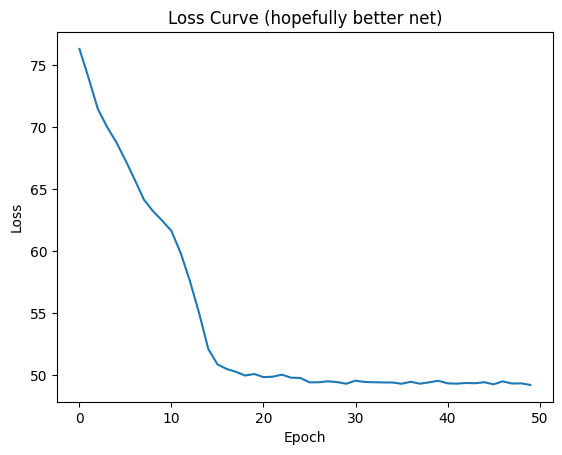

In [32]:
plot_loss_curve(losses, 'hopefully better net')

In [33]:
x_test = x_test.to('cpu')
y_test = y_test.to('cpu')
preds = get_preds(hopefully_better_net, x_test)
log_preds = torch.log(preds)
nll_preds = torch.nn.functional.nll_loss(log_preds, y_test, reduction='none')

n_items_to_print = 10
pretty_print_preds(x_test, preds, n_items_to_print, nll_preds)

enteras de (nll=7.662591457366943)
niño de (nll=0.8591830730438232)
influencia de (nll=1.0417397022247314)
niños se (nll=2.3915300369262695)
mental , (nll=0.003558402881026268)
al público (nll=8.160520553588867)
al público (nll=3.9232256412506104)
febriles. hombre (nll=7.662510871887207)
llevó a (nll=0.7558661103248596)
no le (nll=7.905008316040039)


In [38]:
initial_words = ['abandonado', 'coronel', 'cocina']

for w in initial_words:
  sent, sent_nll = generate_sentence(hopefully_better_net, w, token_to_idx, idx_to_token)
  print(sent, f'(nll={sent_nll})')

abandonado por las descripciones hombre más grande se guardaba la tremenda de marzo , frente a las descripciones hombre más (nll=157.26046752929688)
coronel aureliano , frente a las descripciones hombre más grande se guardaba la tremenda de marzo , frente a las (nll=167.231689453125)
cocina de marzo , frente a las descripciones hombre más grande se guardaba la tremenda de marzo , frente a (nll=158.21925354003906)
